## Import Libraries

In [22]:
import time
import copy
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs
from scipy.spatial import distance
from deap import base, creator, tools

np.random.seed(3)

%matplotlib inline

---

## Generate Data

### Generate Cities Layout

In [39]:
num_cities = 30

In [40]:
# Define the center box within which cities will be generated
center_box = (100, 200)

# Generate random city coordinates using make_blobs function
cities_coord, _ = make_blobs(n_samples = num_cities,
                             centers = 2,
                             cluster_std = 20,
                             center_box = center_box,
                             random_state = 2)

# Create a list of city names, represented by integers
cities_names = [i for i in range(num_cities)]

# Create a dictionary mapping city names to their respective coordinates
cities_coord_dict = {name: coord for name, coord in zip(cities_names, cities_coord)}

### Plot Cities Layout

In [41]:
# Define the size of the plot
plot_size = 15

# Define the width and height of the plot
plot_width = 16
plot_height = 8

# Define a dictionary of parameters for customizing plot settings
params = {
    'legend.fontsize': 'large',                   # Set legend font size to 'large'
    'figure.figsize': (plot_width, plot_height),  # Set the figure size 
    'axes.labelsize': plot_size,                  # Set the label font size for axes
    'axes.titlesize': plot_size,                  # Set the title font size for axes
    'xtick.labelsize': plot_size * 0.75,          # Set the x-axis tick label font size
    'ytick.labelsize': plot_size * 0.75,          # Set the y-axis tick label font size
    'axes.titlepad': 25                           # Set padding for the title of the axes
}

# Update the Matplotlib parameters using the defined dictionary
plt.rcParams.update(params)

C:\Users\bianc\AppData\Local\Temp\ipykernel_17884\3939993226.py:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[:, 0], cities_coord[:, 1], s = plot_size * 2, cmap = 'viridis');


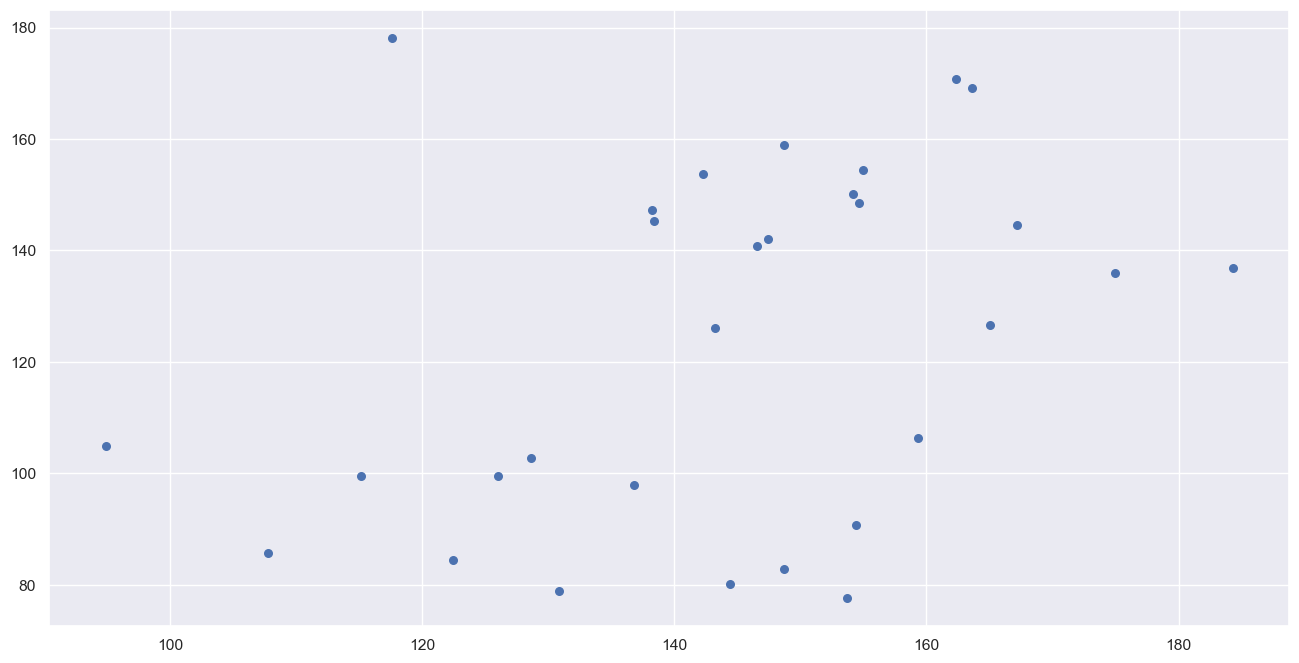

In [42]:
plt.scatter(cities_coord[:, 0], cities_coord[:, 1], s = plot_size * 2, cmap = 'viridis');

### Compute Distance Between Cities

In [43]:
dist_matrix = distance.cdist(cities_coord, cities_coord, 'euclidean')

---

## Define Useful Functions

### Chromosome Creation Function

In [44]:
def chromo_create(_cities_names):
    
    # Create a deep copy of the input list '_cities_names'
    chromo = copy.deepcopy(_cities_names)
    
    # Shuffle the elements in the 'chromo' list randomly
    np.random.shuffle(chromo)
    
    return chromo

### Fitness Function

In [45]:
def chromo_eval(_dist_matrix, _chromo):
    dist = 0  # Initialize the total distance to 0
    
    # Iterate through the chromosome to calculate the total distance
    for p in range(len(_chromo) - 1):
        _i = _chromo[p]  # Get the index of city i
        _j = _chromo[p+1]  # Get the index of city j
        
        # Add the distance between city i and city j to the total distance
        dist += _dist_matrix[_i][_j]
    
    # Add the distance from the last city back to the first city to complete the tour
    dist += _dist_matrix[_chromo[-1], _chromo[0]]
    
    return dist,

---

## Solve TSP w/ Genetic Algorithms (DEAP)

### Setup Genetic Algorithm Parameters

In [46]:
# Create a toolbox 'tb' for defining genetic algorithm components
tb = base.Toolbox()

# Define a fitness function class 'Fitness_Func' with a single objective (-1.0 for minimization)
creator.create('Fitness_Func', base.Fitness, weights=(-1.0,))

# Define an individual class 'Individual' as a list with the 'Fitness_Func' assigned as its fitness attribute
creator.create('Individual', list, fitness=creator.Fitness_Func)

In [47]:
num_population = 200
num_generations = 1000
prob_crossover = .4
prob_mutation = .6

In [48]:
# Register 'indexes' function, which creates a chromosome, with the city names
tb.register('indexes', chromo_create, cities_names)

# Register 'individual' function to initialize individuals using 'initIterate' with 'creator.Individual' and 'tb.indexes'
tb.register('individual', tools.initIterate, creator.Individual, tb.indexes)

# Register 'population' function to initialize a population using 'initRepeat' with 'list' and 'tb.individual'
tb.register('population', tools.initRepeat, list, tb.individual)

# Register 'evaluate' function to evaluate individuals using 'chromo_eval' function and 'dist_matrix'
tb.register('evaluate', chromo_eval, dist_matrix)

# Register 'select' function for tournament selection using 'selTournament'
tb.register('select', tools.selTournament)

# Register 'mate' function for partially matched crossover using 'cxPartialyMatched'
tb.register('mate', tools.cxPartialyMatched)

# Register 'mutate' function for shuffling indexes mutation using 'mutShuffleIndexes'
tb.register('mutate', tools.mutShuffleIndexes)


### Create Initial Population

In [49]:
population = tb.population(n=num_population)

### Calculate Fitness of All Chromosomoes in the Population

In [50]:
# Calculate the fitness values for the entire population using the 'evaluate' function registered in the toolbox
fitness_set = list(tb.map(tb.evaluate, population))

# Assign the calculated fitness values to the individuals in the population
for ind, fit in zip(population, fitness_set):
    ind.fitness.values = fit

### Selection, Crossover and Mutation

In [51]:
# Initialize lists to store the best fitness and solutions over generations
best_fit_list = []  # List to store the best fitness values
best_sol_list = []  # List to store the best solutions (individuals)

# Initialize the best fitness with positive infinity to ensure any initial solution is better
best_fit = np.Inf

# Measure execution time
start = time.time()

for gen in range(0, num_generations):
    
    # Print generation number and best fitness every 50 generations
    if (gen % 50 == 0):
        print(f'Generation: {gen:4} | Fitness: {best_fit:.2f}' ) 
    
    # Select parents for reproduction using tournament selection
    offspring = tb.select(population, len(population), tournsize = 3)
    offspring = list(map(tb.clone, offspring))
    
    # Apply crossover to pairs of offspring with a certain probability
    for child1, child2 in zip(offspring[0::2], offspring[1::2]):
        if np.random.random() < prob_crossover:
            tb.mate(child1, child2)
            del child1.fitness.values
            del child2.fitness.values

    # Apply mutation to offspring with a certain probability
    for chromo in offspring:
        if np.random.random() < prob_mutation:
            tb.mutate(chromo, indpb=0.01)
            del chromo.fitness.values

    # Identify individuals that need evaluation (fitness is not valid)
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    
    # Evaluate the fitness for the invalid individuals
    fitness_set = map(tb.evaluate, invalid_ind)
    
    # Assign fitness values to the evaluated individuals
    for ind, fit in zip(invalid_ind, fitness_set):
        ind.fitness.values = fit
    
    # Replace the current population with the offspring population
    population[:] = offspring
    
    # Select the current best solution (individual) and its fitness
    curr_best_sol = tools.selBest(population, 1)[0]
    curr_best_fit = curr_best_sol.fitness.values[0]
    
    # Update the best solution and fitness if a better solution is found
    if curr_best_fit < best_fit:
        best_sol = curr_best_sol
        best_fit = curr_best_fit

    # Append the best fitness and solution to the respective lists
    best_fit_list.append(best_fit)
    best_sol_list.append(best_sol)

# Stop measuring execution time
end = time.time()

Generation:    0 | Fitness: inf
Generation:   50 | Fitness: 555.59
Generation:  100 | Fitness: 458.53
Generation:  150 | Fitness: 455.38
Generation:  200 | Fitness: 452.15
Generation:  250 | Fitness: 452.15
Generation:  300 | Fitness: 452.15
Generation:  350 | Fitness: 452.15
Generation:  400 | Fitness: 452.15
Generation:  450 | Fitness: 452.15
Generation:  500 | Fitness: 452.15
Generation:  550 | Fitness: 452.15
Generation:  600 | Fitness: 452.15
Generation:  650 | Fitness: 452.15
Generation:  700 | Fitness: 452.15
Generation:  750 | Fitness: 452.15
Generation:  800 | Fitness: 452.15
Generation:  850 | Fitness: 452.15
Generation:  900 | Fitness: 452.15
Generation:  950 | Fitness: 452.15


### Plot Fitness for Each Generation

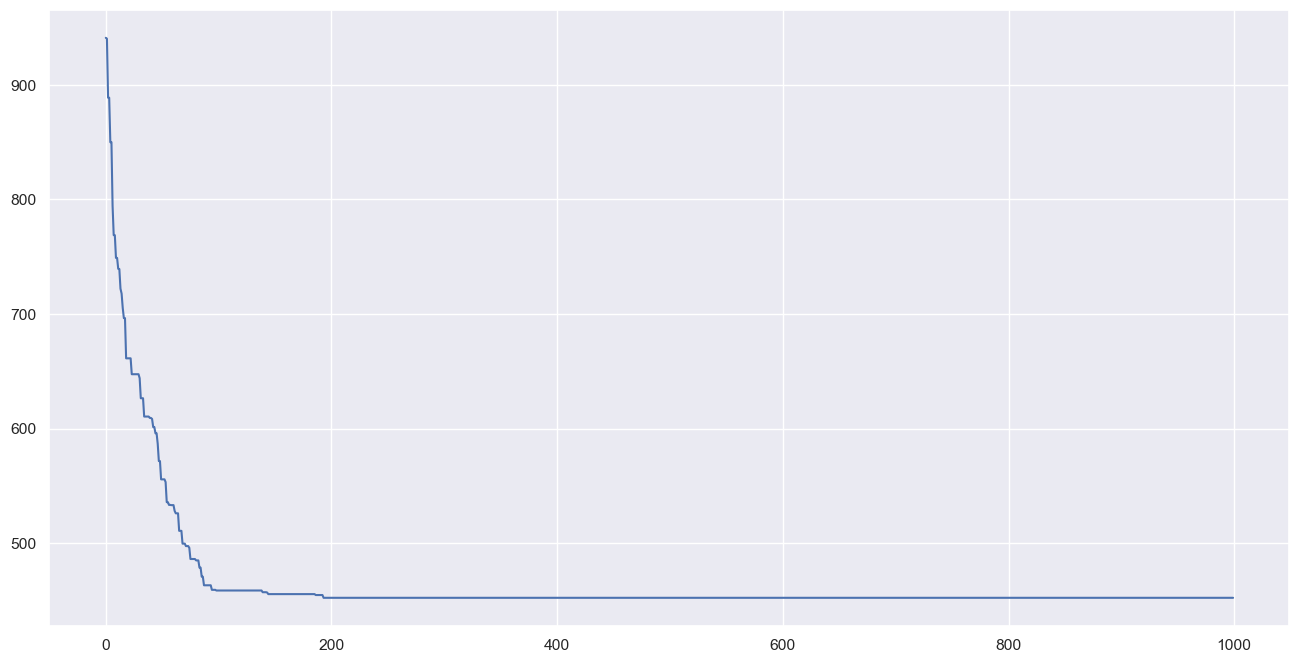

In [53]:
plt.plot(best_fit_list)
plt.show()

---

## Solution

In [54]:
print(f"Best solution: {best_sol}")
print(f"Execution time: {round((end - start), 2)} seconds")

Best solution: [10, 12, 19, 24, 13, 18, 4, 9, 17, 25, 7, 29, 0, 20, 14, 15, 22, 16, 6, 23, 28, 5, 11, 27, 21, 8, 26, 1, 2, 3]
Execution time: 34.37 seconds


C:\Users\bianc\AppData\Local\Temp\ipykernel_17884\1884110464.py:5: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(cities_coord[:, 0],


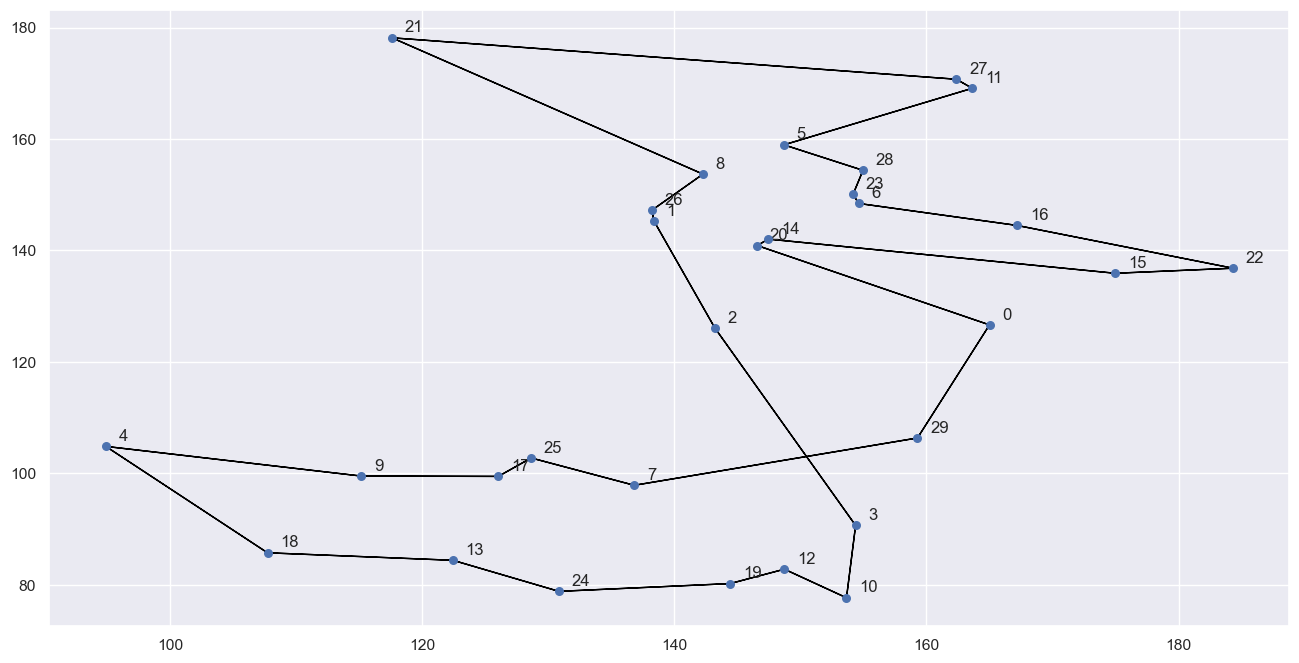

In [55]:
# Create a new solution by appending the first city to the end to complete the tour
final_sol = best_sol + best_sol[0:1]

# Create a scatter plot of city coordinates with customized marker size and colormap
plt.scatter(cities_coord[:, 0], 
            cities_coord[:, 1], 
            s = plot_size * 2, 
            cmap='viridis',
            zorder=10000)  # Set the z-order to ensure cities are plotted on top

# Annotate each city with its name near its coordinates
for i, txt in enumerate(cities_names):
    plt.annotate(txt, (cities_coord[i, 0] + 1, cities_coord[i, 1] + 1))

# Create lines (arrows) connecting the cities in the final solution to visualize the tour
lines = []
for p in range(len(final_sol) - 1):
    i = final_sol[p]
    j = final_sol[p+1]
    colour = 'black'  # Define arrow color
    
    # Draw an arrow from city i to city j
    plt.arrow(cities_coord[i][0], 
              cities_coord[i][1],
              cities_coord[j][0] - cities_coord[i][0], 
              cities_coord[j][1] - cities_coord[i][1], 
              color=colour)